Proposed Trading Strategy
-----
-  We place bids and asks at ALL times on levels 2, 3, 4, and 5. 
-  We place the orders above in an effort to gain valuable queue positions on our level 2-bid/ask orders.
-  When our queue position on our level 2 bid or ask orders reaches the top X% of the queue (X set to like 5% or 10%) we activate our strategy for the given direction.
-  Only when our strategy is active do we place any level 1 orders.
-  Now of course it is impossible to know the relative queue position in practice but it can be estimated fairly accurately, so here we will use the actual queue position (or add in some noise if desired).
-  Once our strategy is active, we look at our RNN predictions for next_midprice_move.
-  Given a positive (negative) price move signal, we place a limit buy (sell) order on the level 1 ask (bid). This order is immediately executed (as it is in a sense a market order).
-  We then wait until the midprice spread changes. If we predict the movement correctly, with high probability, we will make the spread once our level 2 order is filled. 
-  When we predict incorrectly, to avoid further loss, we close our position and in most cases lose double the spread.
-  We continue to repeat this process.


In [1]:
import pandas as pd
import numpy as np
import os
import math
import sys
from matplotlib import pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10
sys.path.insert(0, os.path.join(os.getcwd(), 'code'))

import OrderBook as ob
import OrderUtil as ou
import TradingStrategySimulator as tss


In [2]:
#load in intc OrderBook data
book = ob.OrderBook(message_filename='INTC_message.csv', orderbook_filename='INTC_OrderBook.csv')

Perfectly Accurate Model
--------
Here we use an ideal 100% accurate model to see whether or not our strategy can be profitable

In [3]:
strat = {1: ([2, 3, 4, 5], [2, 3, 4, 5]),
         -1 : ([2, 3, 4, 5], [2, 3, 4, 5])}
midprice_df = book.get_midprice_data(numupdates=1, t_start=34210, t_end=50000, tick_size=100, next_move=True)
midprice_df.dropna(inplace=True)

backtester = tss.StrategyLossEstimation(book=book, midprice_df=midprice_df, mkt_order_on_move_predictions=True,
                                              strategy=strat,
                                              max_exposure_dict={1:0, -1:0}, relative_queue=0.25, 
                                              set_edge_queue=0.25, accuracy_rate=1, tick_size=100, queue_tol=0.5)
backtester.run_strategy_simulation()

1.0
Current time:        34210.716829066
Current pnl: 0.0
market sell at 275000
limit bid executed at 274900
market buy at 275000
market buy at 275100
limit ask executed at 275200
market buy at 275400
limit ask executed at 275500
market buy at 275500
limit ask executed at 275600
market buy at 275600
limit ask executed at 275700
limit bid executed at 275400
market buy at 275700
market buy at 275800
limit ask executed at 275900
limit bid executed at 275700
market sell at 275700
limit bid executed at 275600
market sell at 275600
limit bid executed at 275500
limit bid executed at 275400
limit bid executed at 275300
market sell at 275300
limit bid executed at 275200
market sell at 275200
limit bid executed at 275100
market sell at 275100
limit bid executed at 275000
market sell at 275000
limit bid executed at 274900
limit bid executed at 274800
market sell at 274800
limit bid executed at 274700
market sell at 274700
limit bid executed at 274600
market buy at 274800
limit ask executed at 274

market sell at 272600
limit bid executed at 272500
market sell at 272500
limit bid executed at 272400
market sell at 272400
limit bid executed at 272300
market sell at 272300
limit bid executed at 272200
market sell at 272200
limit bid executed at 272100
market sell at 272100
limit bid executed at 272000
Current time:        40471.015370924
Current pnl: 13500.0
market sell at 272000
limit bid executed at 271900
market sell at 271900
limit bid executed at 271800
market sell at 271800
limit bid executed at 271700
Current time:        40863.947867609
Current pnl: 13800.0
market buy at 272200
limit ask executed at 272300
Current time:        41364.94105919
Current pnl: 13900.0
market sell at 271800
limit bid executed at 271700
market buy at 272200
limit ask executed at 272300
Current time:        41946.57900228
Current pnl: 14100.0
market sell at 271800
limit bid executed at 271700
market sell at 271700
limit bid executed at 271600
market sell at 271600
limit bid executed at 271500
market 

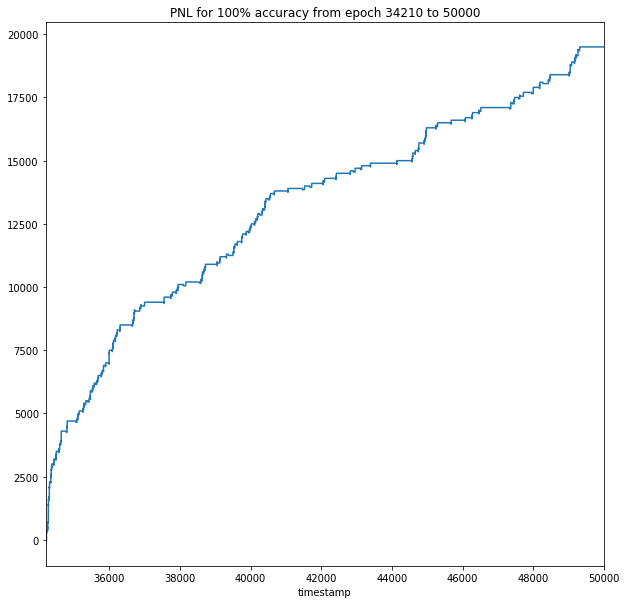

In [4]:
pnls = backtester._strategy_simulator.get_pnl_series()
pnls.cumsum().plot()
plt.title('PNL for 100% accuracy from epoch 34210 to 50000')
plt.show()

70% Accuracy
---------
Here we test a hypothetical model that has an average of 70% out of sample accuracy

In [8]:
strat = {1: ([2, 3, 4, 5], [2, 3, 4, 5]),
         -1 : ([2, 3, 4, 5], [2, 3, 4, 5])}
midprice_df = book.get_midprice_data(numupdates=1, t_start=34210, t_end=50000, tick_size=100, next_move=True)
midprice_df.dropna(inplace=True)
backtester = tss.StrategyLossEstimation(book=book, midprice_df=midprice_df, mkt_order_on_move_predictions=True,
                                        strategy=strat,
                                        max_exposure_dict={1:0, -1:0}, relative_queue=0.25, 
                                        set_edge_queue=0.25, accuracy_rate=0.7, tick_size=100, queue_tol=0.5)
backtester.run_strategy_simulation()

0.6991607109928979
Current time:        34210.716829066
Current pnl: 0.0
market sell at 275000
limit bid executed at 274900
market buy at 275000
market buy at 275100
limit ask executed at 275200
market buy at 275400
limit ask executed at 275500
market buy at 275500
limit ask executed at 275600
market buy at 275600
limit ask executed at 275700
limit bid executed at 275400
market buy at 275700
market buy at 275800
limit ask executed at 275900
limit bid executed at 275700
market sell at 275700
limit bid executed at 275600
market sell at 275600
limit bid executed at 275500
market sell at 275500
market sell at 275500
limit bid executed at 275400
market sell at 275400
market sell at 275400
market sell at 275400
limit bid executed at 275300
market sell at 275300
limit bid executed at 275200
market sell at 275200
limit bid executed at 275100
market sell at 275100
limit bid executed at 275000
market sell at 275000
limit bid executed at 274900
limit bid executed at 274800
market sell at 274800
l

limit bid executed at 274100
market sell at 274100
market sell at 274100
market sell at 274100
limit bid executed at 274000
market sell at 274000
limit bid executed at 273900
market sell at 273900
limit bid executed at 273800
market sell at 273800
market sell at 273800
limit bid executed at 273700
Current time:        39639.138677457006
Current pnl: 2800.0
market sell at 273700
limit bid executed at 273600
market sell at 273600
limit bid executed at 273500
market sell at 273500
limit bid executed at 273400
market sell at 273400
limit bid executed at 273300
market sell at 273300
limit bid executed at 273200
market sell at 273200
limit bid executed at 273100
market sell at 273100
limit bid executed at 273000
market sell at 273000
Current time:        40080.394255224
Current pnl: 3300.0
market sell at 273000
limit bid executed at 272900
market sell at 272900
limit bid executed at 272800
market sell at 272800
limit bid executed at 272700
market sell at 272700
limit bid executed at 272600
m

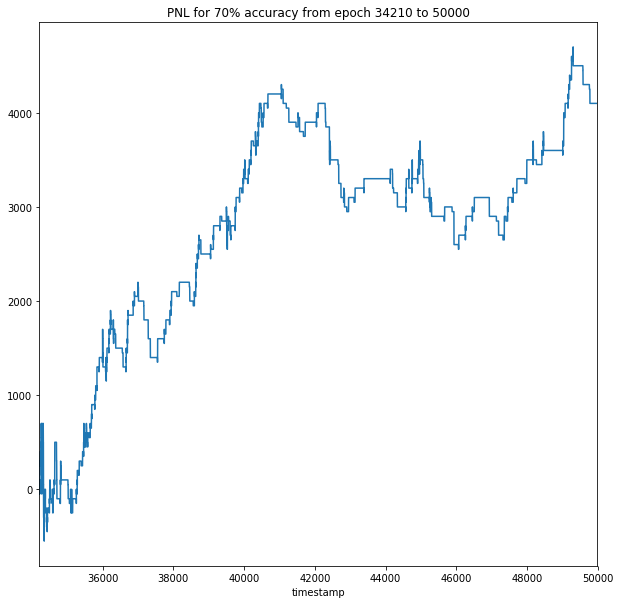

In [9]:
pnls = backtester._strategy_simulator.get_pnl_series()
pnls.cumsum().plot()
plt.title('PNL for 70% accuracy from epoch 34210 to 50000')
plt.show()

Strategy Tested Using Simple Prediction Model
--------
When bid level 1 quantity is greater than or equal to ask level 1 quantity we predict an up move, otherwise we predict a down move.

In [10]:
strat = {1: ([2, 3, 4, 5], [2, 3, 4, 5]),
         -1 : ([2, 3, 4, 5], [2, 3, 4, 5])}
midprice_df = book.get_midprice_data(numupdates=1, t_start=34210, t_end=50000, tick_size=100, next_move=True)
midprice_df.dropna(inplace=True)
pred = (midprice_df['bq1'] >= midprice_df['aq1']).astype(int)
pred = 2.0*(pred - 0.5)
backtester = tss.TradingStrategyBacktester(book=book, midprice_df=midprice_df, mkt_order_on_move_predictions=True,
                                           strategy=strat, predictions=pred,
                                           max_exposure_dict={1:0, -1:0}, relative_queue=0.25, 
                                           set_edge_queue=0.25, tick_size=100, queue_tol=0.5)
backtester.run_strategy()

0.6003263280826548
Current time:        34210.716829066
Current pnl: 0.0
limit bid executed at 274900
market sell at 274900
market sell at 274900
market buy at 275100
limit ask executed at 275200
market sell at 275000
limit ask executed at 275500
market buy at 275500
limit ask executed at 275600
market buy at 275600
limit ask executed at 275700
limit bid executed at 275400
market buy at 275700
market buy at 275800
limit ask executed at 275900
limit bid executed at 275700
limit bid executed at 275600
market sell at 275600
limit bid executed at 275500
market sell at 275500
limit bid executed at 275400
market sell at 275400
limit bid executed at 275300
market sell at 275300
limit bid executed at 275200
market sell at 275200
limit bid executed at 275100
market sell at 275100
limit bid executed at 275000
market sell at 275000
limit bid executed at 274900
limit bid executed at 274800
market sell at 274800
limit bid executed at 274700
market sell at 274700
limit bid executed at 274600
market 

market sell at 273900
limit bid executed at 273800
market sell at 273800
limit bid executed at 273700
market sell at 273700
Current time:        39639.138677457006
Current pnl: -700.0
market sell at 273700
limit bid executed at 273600
market sell at 273600
limit bid executed at 273500
market sell at 273500
limit bid executed at 273400
market sell at 273400
market sell at 273400
market sell at 273400
limit bid executed at 273300
market sell at 273300
market sell at 273300
limit bid executed at 273200
market sell at 273200
limit bid executed at 273100
market sell at 273100
limit bid executed at 273000
market sell at 273000
Current time:        40080.394255224
Current pnl: -800.0
market sell at 273000
limit bid executed at 272900
market sell at 272900
market sell at 272900
limit bid executed at 272800
limit bid executed at 272700
market sell at 272700
limit bid executed at 272600
market sell at 272600
market sell at 272600
market sell at 272600
limit bid executed at 272500
market sell at 

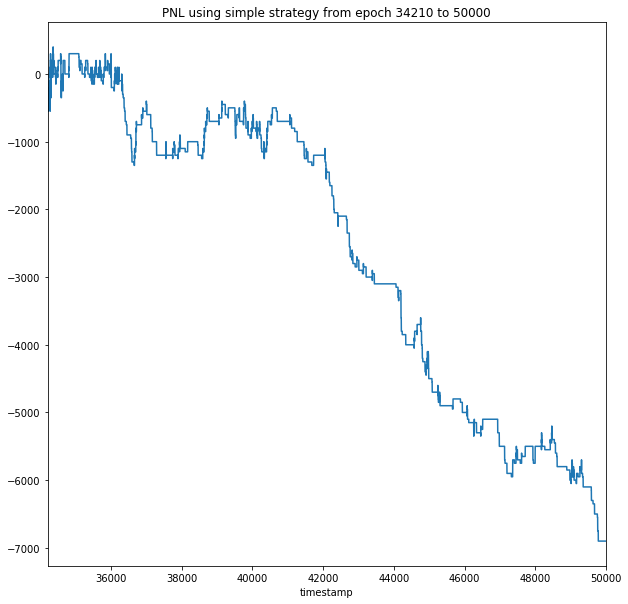

In [11]:
pnls = backtester.get_pnl_series()
pnls.cumsum().plot()
plt.title('PNL using simple strategy from epoch 34210 to 50000')
plt.show()